In [1]:
# Math Stuff
import numpy as np
import pandas as pd

# Proceesing librairies
from natsort import natsorted
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler, Normalizer
import imblearn

# Side Stuff
import joblib
import warnings
import colorama as col
import pyttsx3
engine = pyttsx3.init()
from tqdm import tqdm, tqdm_notebook, tqdm_pandas

# Random Seed
seed_value = 42
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)


# Technical analysis
from finta import TA

# Plotting stuff
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style="darkgrid")

# Time Stuff
import time
import datetime as dt

print('Imblearn version ',imblearn.__version__)
print('Pandas version ',pd.__version__)
print('Numpy version ',np.__version__)
print('Tensorflow version ',tf.__version__)
print('Joblib version ',joblib.__version__)

warnings.filterwarnings('ignore')


Imblearn version  0.7.0
Pandas version  1.2.2
Numpy version  1.19.5
Tensorflow version  2.4.1
Joblib version  1.0.1


In [2]:
TIK = ['AUD','NZD','GBP','JPY','CHF','CAD','SEK','NOK','ILS','MXN','USD','EUR']
RATE = [0.776,0.721,1.3912,1/105.91,1/0.892,1/1.2681,1/8.2884,1/8.4261,1/3.2385,1/20.1564,1,1.21]
df_ratefx = pd.DataFrame(index=TIK)
df_ratefx['rate'] = RATE

x = 'EUR/USD'
_period = 'm5'
_period2 = 'H1'
_ticker = x.replace('/','')
_start = '2010-01-01' # start the train there '2010-01-01'
_mid = '2016-06-30' # stop the train and begin the test there '2016-08-31'
_stop = '2017-12-31' # stop the test there. After that, it is kept for oos '2017-12-31'
_last = '2021-04-29' # '2020-12-31'
_nb_bougie_exit = 555555555555555
_trigger_reengage = 0
_trigger_target = 1
_trigger_invers = 0
_trigger_sl = 1
_trigger_rsi = 0
_verbose = 0
_cash_ini = 200000
_target = 0.002
_sl = 0.001
_exposure = 1
_rate = df_ratefx.loc[x[4:],'rate']
_size = _cash_ini / df_ratefx.loc[x[:3],'rate']
_trigger_spread = 0.025
_no_access = 0


In [3]:
def klines(df):
    _condition1 = df.Close >= df.Open
    df['Color'] = np.where(_condition1,1,-1)
    _condition2 = df.Color = 1
    df['UpperShadow'] = np.where(_condition2,(df.High-df.Close),(df.High-df.Open))
    df['LowerShadow'] = np.where(_condition2,(df.Open-df.Low),(df.Close-df.Low))
    df['Body'] = abs(df.Close-df.Open)
    return (df)

In [4]:
def undersample3(df):
    
    print('Avant Resampling :')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    print('Classe -1',df[df.Signal==-1].shape[0])

    # Class count
    count_class_0, count_class_1, count_class_2 = df_train.Signal.value_counts()
    # Divide by class
    df_class_0 = df[df.Signal== 0]
    df_class_1 = df[df.Signal != 0]

    df_class_0_under = df_class_0.sample(int((count_class_1+count_class_1)/1.5))
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Signal.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    print('Classe -1',df[df.Signal==-1].shape[0])
    return df

def undersample2(df):
    
    print('Avant Resampling :')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])

    # Class count
    count_class_0, count_class_1 = df.Signal.value_counts()
    # Divide by class
    df_class_0 = df[df.Signal== 0]
    df_class_1 = df[df.Signal != 0]

    df_class_0_under = df_class_0.sample(int((count_class_1)))
    df = pd.concat([df_class_0_under, df_class_1], axis=0)
    df = df.sort_index()
    print('Random under-sampling:')
    print(df.Signal.value_counts())

    # Classify and report the results
    print('\nAprès resample:')
    print('Classe 0',df[df.Signal==0].shape[0])
    print('Classe 1',df[df.Signal==1].shape[0])
    return df

In [5]:
def split_df(df):
    """[Split the dtaframe in train/test/oos and reduce train and test to dataframe with signal!=0 only]

    Args:
        df ([pandas]): [the datframe to split already featured]
        _start ([date]): [beginning of the df]
        _mid ([date]): [stop of the train and beginning of the test]
        _stop ([date]): [stop of the test and beginning of the oos]
        _last ([date]): [end of the oos]
    """    
    df = df.dropna()
    df['Date'] = pd.to_datetime(df.index)
    
    df_train = df[(df.Date>=_start)&(df.Date<=_mid)]
    df_test = df[(df.Date>_mid)&(df.Date<=_stop)]
    df_oos = df[(df.Date>_stop)&(df.Date <= _last)]
    df_train = df_train.drop(['Date'],axis=1)
    df_test = df_test.drop(['Date'],axis=1)
    df_oos = df_oos.drop(['Date'],axis=1)
    return(df_train, df_test,df_oos)

In [6]:
def strategy(df):
    ##### CONDITIONS LONG
    _condition_1 = (df.slow_K5 < 20) & (df.slow_K5.shift(1) < df.slow_D5.shift(1)) & (df.slow_K5 > df.slow_D5)

    ##### CONDITIONS SHORT
    _condition_1_bar = (df.slow_K5 > 80) & (df.slow_K5.shift(1) > df.slow_D5.shift(1)) & (df.slow_K5 < df.slow_D5)

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    try:
        df = df.drop(['Symbol','Date','DateIndex','SB_Gamma'], axis=1)
    except:
        pass
    return(df.sort_index(axis=0)) 

def strategy5(df,_window=40):

    #df['RSI_2'] = TA.RSI(ohlc=df,int=2,str='Close')

    df['Window_High_Ask'] = df.HighAsk.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite SL Short
    df['Window_High_Bid'] = df.HighBid.iloc[::-1].rolling(_window).max().iloc[::-1] # Limite Target Long
    df['Window_Low_Ask'] = df.LowAsk.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite Target Short
    df['Window_Low_Bid'] = df.LowBid.iloc[::-1].rolling(_window).min().iloc[::-1] # Limite SL Long
    df['Window_sl_Short'] = df.CloseBid + (df.CloseBid * _sl) # Short pour SL
    df['Window_sl_Long'] = df.CloseAsk - (df.CloseAsk * _sl) # Long pour SL
    df['Window_tp_Short'] = df.CloseBid - (df.CloseBid * _target) # Short pour TP
    df['Window_tp_Long'] = df.CloseAsk + (df.CloseAsk * _target) # Long pour TP

    ##### CONDITIONS LONG
    _condition_1 = (df['Window_tp_Long'] <= df['Window_High_Bid']) & (df['Window_sl_Long'] <= df['Window_Low_Bid'])

    ##### CONDITIONS SHORT
    _condition_1_bar = (df['Window_tp_Short'] >= df['Window_Low_Ask']) & (df['Window_sl_Short'] >= df['Window_High_Ask'])

    ##### 1 condition
    df['Signal'] = np.where(_condition_1,1,np.where(_condition_1_bar,-1,0))
    df = df.drop(['Symbol','Date','DateIndex','Window_High_Ask','Window_High_Bid','Window_Low_Ask','Window_Low_Bid','Window_sl_Short','Window_sl_Long','Window_tp_Short','Window_tp_Long'], axis=1)
    return(df.sort_index(axis=0))

%%time

_nb_looser = 10000000000
TRACKER = []
_year_bottom = _start
_year_top = _stop

#scaler = Normalizer()
scaler = MinMaxScaler()
# scaler = StandardScaler()
df = joblib.load('BASES/EURUSD_m5')


df = klines(df)

df = strategy(df)

print()
print(col.Fore.CYAN,'###############################################################################################')
print(' #################################### TRAIN/TEST WITHOUT AI ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)


TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)


print()
print(col.Fore.BLUE,'###############################################################################################')
print(' #################################### DENOISING & ENHANCING ####################################')
print(' ###############################################################################################',col.Style.RESET_ALL)
while _nb_looser > 0 :
    
    df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)

    _condition1 = ((df.Signal==1)&(df.TRACKER==1))
    _condition2 = ((df.Signal==-1)&(df.TRACKER==1))
    df['Signal'] = np.where(_condition1,1,np.where(_condition2,-1,0))

    ##### Purification of signal by denoising and enhancing
    TRACKER,_nb_looser = bt(df,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)

print('Shape de features',df.shape)
df['TRACKER'] = np.where(df.index.isin(TRACKER),1,0)
df['Valid'] = np.where(_condition1,1,np.where(_condition2,-1,0))
df = strategy(df)
df_raw = df.copy()

#df = undersample2(df)

df_train, df_test, df_oos = split_df(df)

df_train.sort_index(inplace=True)
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and i!= 'TRACKER':
        df_train[i] = scaler.fit_transform(df_train[i].values.reshape(-1, 1))
        df_test[i] = scaler.fit_transform(df_test[i].values.reshape(-1, 1))
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

df_train = df_train.dropna()
df_test = df_test.dropna()
df_oos = df_oos.dropna()

df_oos= df_oos.reindex(natsorted(df_oos.columns), axis=1)
df_test= df_test.reindex(natsorted(df_test.columns), axis=1)
df_train = df_train.reindex(natsorted(df_train.columns), axis=1)


joblib.dump(df,'BASES/multi_df_EURUSD_m5')
joblib.dump(df_raw,'BASES/multi_df_raw_EURUSD_m5')
joblib.dump(df_train,'BASES/multi_df_train_EURUSD_m5')
joblib.dump(df_test,'BASES/multi_df_test_EURUSD_m5')
joblib.dump(df_oos,'BASES/multi_df_oos_EURUSD_m5')

## DEBUT BASE PREPAREE

In [14]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import Recall, Precision, Metric
from keras.utils import to_categorical
# Disable eager execution
tf.compat.v1.disable_eager_execution()



In [16]:
%%time
df = joblib.load('BASES/multi_df_EURUSD_m5')
df_raw = joblib.load('BASES/multi_df_raw_EURUSD_m5')
df_train = joblib.load('BASES/multi_df_train_EURUSD_m5')
df_test = joblib.load('BASES/multi_df_test_EURUSD_m5')
df_oos = joblib.load('BASES/multi_df_oos_EURUSD_m5')

X_train = df_train.drop(['Valid','Signal','TRACKER'],axis=1)
y_train = df_train[['Valid']]
X_test = df_test.drop(['Valid','Signal','TRACKER'],axis=1)
y_test = df_test[['Valid']]
X_oos = df_oos.drop(['Valid','Signal','TRACKER'],axis=1)

# Première variable pour proba de signal à 0, et deuxième pour proba de signal ) 1
y_train = to_categorical(y_train, 3) 
y_test = to_categorical(y_test, 3)

#X_train = X_train.stack()
#X_test = X_test.stack()

X_train = X_train.values.reshape(-1,X_train.shape[1])
X_test = X_test.values.reshape(-1,X_test.shape[1])
X_oos = X_oos.values.reshape(-1,X_oos.shape[1])

test = strategy(df_raw)
#X_train = X_train.reshape(-1,X_train.shape[1]*X_train.shape[1])
#X_test = X_test.reshape(-1,X_test.shape[1]*X_test.shape[1])
print('Premier ytrain (signal à 0):',y_train[0],' et premier signal de df_raw :',test.Valid[20])
print('Deuxieme ytrain (signal à 1):',y_train[1],' et deuxième signal de df_raw :',test.Valid[21])
del test


Premier ytrain (signal à 0): [1. 0. 0.]  et premier signal de df_raw : 0
Deuxieme ytrain (signal à 1): [1. 0. 0.]  et deuxième signal de df_raw : 0
CPU times: user 742 ms, sys: 588 ms, total: 1.33 s
Wall time: 1.31 s


In [17]:
len(df_train),len(df_test),len(df_oos),len(df),len(df_raw),len(X_train), len(X_test),len(X_oos)

(365344, 108797, 240612, 820907, 820907, 365344, 108797, 240612)

In [18]:
%%time
# univariate data preparation
from numpy import array
def split_sequence(sequence, sequence_y, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequence[i:end_ix+1], sequence_y[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)
 
# define input sequence
raw_seq = X_train
raw_seq_y = y_train
raw_seqt = X_test
raw_seq_yt = y_test
raw_seq_oos = X_oos
# choose a number of time steps
n_steps = 11
# split into samples
X_train, y_train = split_sequence(raw_seq,raw_seq_y, n_steps)
X_test, y_test = split_sequence(raw_seqt,raw_seq_yt, n_steps)
X_oos, _ = split_sequence(raw_seq_oos,raw_seq_y, n_steps)



CPU times: user 2.02 s, sys: 890 ms, total: 2.91 s
Wall time: 2.91 s


In [19]:
len(df_train),len(df_test),len(df_oos),len(df),len(df_raw),len(X_train), len(X_test),len(X_oos),len(df_train[df_train.Signal!=0])+len(df_train[df_train.Signal==0])-11

(365344, 108797, 240612, 820907, 820907, 365333, 108786, 240601, 365333)

In [20]:
df.shape,df_train.shape, df_test.shape,df_oos.shape,len(X_oos)+11

((820907, 66), (365344, 66), (108797, 66), (240612, 66), 240612)

In [21]:
X_train.shape, X_test.shape,  X_oos.shape

((365333, 12, 63), (108786, 12, 63), (240601, 12, 63))

In [22]:
len(X_train[0]),len(X_test[0]),len(X_oos[0])

(12, 12, 12)

<AxesSubplot:ylabel='Valid'>

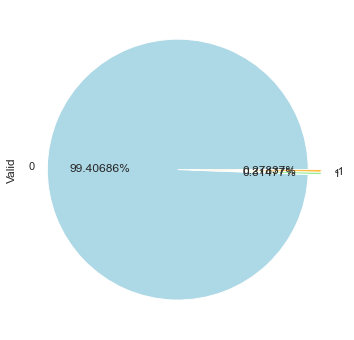

In [24]:
plt.figure(figsize=(24,6))
df_train.Valid.value_counts().plot(kind='pie', autopct='%0.05f%%', colors=['lightblue', 'lightgreen', 'orange'], explode=(0.05, 0.05, 0.05))

## NAIVE BUILD ON

In [25]:

model  = tf.keras.models.Sequential()
_filters = df_train.shape[1]


model.add(tf.keras.layers.Conv1D(filters=63, kernel_size=3, activation='relu',input_shape=(12,63)))

model.add(tf.keras.layers.Conv1D(filters=63, kernel_size=3, activation='relu'))

model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1))

model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=1, activation='relu'))

model.add(tf.keras.layers.MaxPool1D(pool_size=2, strides=1))

model.add(tf.keras.layers.Flatten())

#model.add(tf.keras.layers.Dense(units=63, activation='relu'))

#model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=128, activation='relu'))

model.add(tf.keras.layers.Dropout(0.2))

#model.add(tf.keras.layers.Dense(units=256, activation='relu'))

#model.add(tf.keras.layers.Dropout(0.2))

#model.add(tf.keras.layers.Dense(units=128, activation='relu'))

#model.add(tf.keras.layers.Dropout(0.2))

#model.add(tf.keras.layers.Dense(units=63, activation='relu'))

#model.add(tf.keras.layers.Dropout(0.2))

model.add(tf.keras.layers.Dense(units=3, activation='softmax'))


In [26]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 10, 63)            11970     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 8, 63)             11970     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 7, 63)             0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 7, 32)             2048      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 6, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 192)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               2

In [37]:
%%time

class CategoricalTruePositives(tf.keras.metrics.Metric):

    def __init__(self, num_classes, batch_size,
                 name="categorical_true_positives", **kwargs):
        super(CategoricalTruePositives, self).__init__(name=name, **kwargs)

        self.batch_size = batch_size
        self.num_classes = num_classes    

        self.cat_true_positives = self.add_weight(name="ctp", initializer="zeros")

    def update_state(self, y_true, y_pred, sample_weight=None):     

        y_true = K.argmax(y_true, axis=-1)
        y_pred = K.argmax(y_pred, axis=-1)
        y_true = K.flatten(y_true)

        true_poss = K.sum(K.cast((K.equal(y_true, y_pred)), dtype=tf.float32))

        self.cat_true_positives.assign_add(true_poss)

    def result(self):

        return self.cat_true_positives


METRICS = [
  tf.keras.metrics.CategoricalAccuracy(name='acc'),
  CategoricalTruePositives(3, 12),
]
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=[METRICS,tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])
#model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['sparse_categorical_accuracy',tf.keras.metrics.Precision(),tf.keras.metrics.Recall()])

ValueError: When passing a list of lists as `metrics`, it should have one entry per model output. The model has 1 outputs, but you passed metrics=[[<tensorflow.python.keras.metrics.CategoricalAccuracy object at 0x7fd2726f8b80>, <__main__.CategoricalTruePositives object at 0x7fd2726f8b50>], <tensorflow.python.keras.metrics.Precision object at 0x7fd255c17280>, <tensorflow.python.keras.metrics.Recall object at 0x7fd255c17a90>]

In [30]:
%%time
model.fit(X_train, y_train, epochs=5)

Train on 365333 samples
Epoch 1/15


InvalidArgumentError: Can not squeeze dim[1], expected a dimension of 1, got 3
	 [[{{node metrics_2/sparse_categorical_accuracy/Squeeze}}]]

In [72]:
score = model.evaluate(X_test, y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1]*100,'%')
print("Test Precision:", score[2]*100,'%')
print("Test Recall:", score[3]*100,'%')

Test Score: 0.36145147262057137
Test Accuracy: 9.890441596508026 %
Test Precision: 88.87998461723328 %
Test Recall: 88.87998461723328 %


In [73]:
len(model.predict(X_test).reshape(-1,))

9982

In [74]:
model.predict(X_test).reshape(-1,)

array([0.8283087 , 0.17169124, 0.8514216 , ..., 0.12792106, 0.9448053 ,
       0.05519468], dtype=float32)

In [82]:
yhat = pd.DataFrame()
yhat['Predict'] = model.predict(X_test).reshape(-1,)
_condition1 = yhat.Predict <= 0.5
_condition2 = yhat.Predict > 0.5
yhat['Predict'] = np.where(_condition1, 0, np.where(_condition2, 1, 999))
yhat.Predict.unique()

array([1, 0])

In [83]:
tf.math.confusion_matrix(y_test.reshape(-1,), yhat.Predict, num_classes=None, weights=None, dtype=tf.dtypes.int32,name=None)

<tf.Tensor 'confusion_matrix_2/ScatterNd:0' shape=(2, 2) dtype=int32>

In [84]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score

y_test = y_test.reshape(-1,)
yhat = yhat.Predict

accu = round(accuracy_score(y_test, yhat) * 100,2)
prec = round(precision_score(y_test, yhat,pos_label=1) * 100,2)
recall = round(recall_score(y_test, yhat) * 100,2)
f1 = round(f1_score(y_test, yhat) * 100,2)


#print('Signaux - Accuracy :' ,accu,'%')
print('Signaux - Precision :',prec,'%')
print('Signaux - Recall :', recall,'%')
print('Achat - F-measure: :' ,f1,'%')
print('\n')
print(classification_report(y_test, yhat, target_names=['Neg', 'Pos']))
conf_matrix = pd.DataFrame(columns=['Bonnes_Estimations','Mauvaises_Estimations'])
tt = confusion_matrix(y_test, yhat, labels=[1,0])    #_model.classes_)

conf_matrix.loc['vrais-réels'] = tt[0]
conf_matrix.loc['faux-réels'] = tt[1]

print(conf_matrix)
print()
print(col.Fore.BLUE,'Signaux pour',col.Fore.YELLOW,x,col.Style.RESET_ALL)
_tp = tt[0][0]
_fn = tt[0][1]
_prec = round((tt[0][0]/(tt[0][0]+tt[0][1]))*100,2)
_rec = round((tt[0][1]/(tt[0][0]+tt[0][1]))*100,2)

print('Vrais signaux trouvés    : ',tt[0][0])
print('Vrais signaux non trouvé :',tt[0][1])
print('Total des vrais signaux  :',tt[0][0]+tt[0][1])

if _prec > 69 :
    print(col.Fore.GREEN,_prec,'%',col.Style.RESET_ALL)
elif _prec < 51 :
    print(col.Fore.RED,_prec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW)
print('Precision : ',_prec,'%')
if _rec > 69  :
    print(col.Fore.GREEN,_rec,'%',col.Style.RESET_ALL)
elif _rec < 51  :
    print(col.Fore.RED,_rec,'%',col.Style.RESET_ALL)
else:
    print(col.Fore.YELLOW)
print('Recall',_rec,'%',col.Style.RESET_ALL)

Signaux - Precision : 88.88 %
Signaux - Recall : 88.88 %
Achat - F-measure: : 88.88 %


              precision    recall  f1-score   support

         Neg       0.89      0.89      0.89      4991
         Pos       0.89      0.89      0.89      4991

    accuracy                           0.89      9982
   macro avg       0.89      0.89      0.89      9982
weighted avg       0.89      0.89      0.89      9982

            Bonnes_Estimations Mauvaises_Estimations
vrais-réels               4436                   555
faux-réels                 555                  4436

 Signaux pour  EUR/USD 
Vrais signaux trouvés    :  4436
Vrais signaux non trouvé : 555
Total des vrais signaux  : 4991
 88.88 % 
Precision :  88.88 %
 11.12 % 
Recall 11.12 % 


In [87]:
%%time
_, _, df_oos = split_df(df_raw)
scaler = MinMaxScaler()
df_train.sort_index(inplace=True)
for i in df.columns.unique():
    if i != 'Signal' and i != 'Color' and i != 'Valid' and 'TRACKER':
        df_oos[i] = scaler.fit_transform(df_oos[i].values.reshape(-1, 1))

df_oos = df_oos.dropna()

df_oos = strategy(df_oos)

df_oos= df_oos.reindex(natsorted(df_oos.columns), axis=1)

print(len(df_oos))

#X_oos = X_oos.values.reshape(-1,X_oos.shape[1])
#print(len(X_oos))
#raw_seqoos = X_oos
#raw_seq_yt = y_test
# choose a number of time steps
#n_steps = 12
# split into samples
#X_oos = split_sequence_oos(raw_seq, n_steps)


240612
CPU times: user 720 ms, sys: 159 ms, total: 879 ms
Wall time: 872 ms


In [86]:
df_oos[df_oos.Signal==0].shape, df_oos[df_oos.Signal==-1].shape,df_oos[df_oos.Signal==1].shape

((208880, 66), (0, 66), (31732, 66))

In [100]:
%%time
test = joblib.load('BASES/EURUSD_m5')
_, _, test = split_df(test)
test = strategy(test)
test[test.Signal==0].shape, test[test.Signal==-1].shape,test[test.Signal==1].shape,test[test.Signal==1].Signal[:12].sum()+abs(test[test.Signal==-1].Signal[:12].sum())

CPU times: user 775 ms, sys: 248 ms, total: 1.02 s
Wall time: 1.01 s


((229192, 63), (5955, 63), (5465, 63), 24)

In [92]:
5955+5465-11398

22

In [94]:
df[df.Signal!=0].Valid.sum()

2722

In [104]:
%%time
# split a univariate sequence into samples
def split_sequence_oos(sequence, sequence_y, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix+1], sequence_y[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = X_oos
raw_seq_y = df_oos.Signal

# choose a number of time steps
n_steps = 11
# split into samples
X_oos, y_oos = split_sequence_oos(raw_seq,raw_seq_y, n_steps)

CPU times: user 220 ms, sys: 176 ms, total: 396 ms
Wall time: 395 ms


In [108]:
len(X_oos),len(y_oos),len(df_oos),len(df_oos[df_oos.Signal!=0]),len(df_oos[df_oos.Signal==0])

(11398, 11398, 240612, 31732, 208880, 22796)

In [94]:
len(X_oos[0])

12

In [109]:
%%time
for i in range(len(X)):
    
    if i<=len(X)-3:
        continue
    print(i,' ',y[i],'\n\n ',X[i])
    

3228   [1. 0.] 

  [[1.90455124e-01 2.15888838e-01 7.08547030e-01 5.02250225e-01
  1.33362181e-01 1.33521252e-01 1.33203106e-01 2.07109233e-01
  1.66682846e-01 1.00000000e+00 1.28089970e-01 1.25243797e-01
  1.41522491e-01 1.41614354e-01 1.41430619e-01 2.01440602e-01
  1.71758747e-01 1.34717135e-01 1.34801806e-01 1.34632462e-01
  2.13599573e-01 1.67462094e-01 1.12619008e-01 8.15483871e-01
  4.56240026e-01 1.32657436e-01 1.24453176e-01 1.25533318e-01
  1.27854853e-01 1.19164728e-01 1.19226737e-01 1.41509085e-01
  1.41553187e-01 1.41464979e-01 2.06436575e-01 1.77732954e-01
  1.62210913e-01 1.63802221e-01 1.63530376e-01 1.63349774e-01
  1.63111954e-01 1.62718174e-01 1.53327260e-01 1.46933159e-01
  1.39251675e-01 5.44711454e-01 2.19115734e-01 3.71518178e-01
  1.83348771e-01 1.96509912e-01 2.05303237e-01 2.16943462e-01
  2.36882144e-01 2.53320778e-01 2.83095927e-01 3.32717287e-01
  1.87336448e-01 5.28005464e-01 1.33956851e-01 5.54502370e-01
  1.41509085e-01 8.86317307e-01 8.26771440e-01]
 [1

In [44]:
df_oos['Valid'].loc[12:,] = y_oos

In [45]:
df_oos.query('Signal == Valid').shape[0],df_oos.shape[0]

(240611, 240612)

In [28]:
%%time
PREDICTAT = []
for idx in df_oos[df_oos.Signal!=0].index:
    idx1 = df_oos.index.get_loc(idx) - 12
    idx2 = df_oos.index.get_loc(idx) + 1
    if idx1 < 0 :
        continue
    if idx2 >= len(df_oos):
        break
    _predictat = split_sequence_oos(df_oos.drop(['Signal','TRACKER','Valid'],axis=1).iloc[idx1:idx2,:],12)
    if _predictat <= 0.5:
        PREDICTAT.append(0)
    else:
        PREDICTAT.append(1)

    

CPU times: user 11min 56s, sys: 3min 8s, total: 15min 5s
Wall time: 14min 58s


In [29]:
joblib.dump(PREDICTAT,'PREDICTAT.dag')

['PREDICTAT.dag']

In [30]:
df_oos['Valid'] = PREDICTAT

ValueError: Length of values (31730) does not match length of index (240612)

In [134]:
df_oos.shape,len(X_oos)

((240612, 66), 3230)

In [131]:
model.predict(X_oos).reshape(-1,).shape

(6460,)

In [132]:
%%time
df_oos['Valid'] = model.predict(X_oos)
_condition1 = df_oos.Valid <= 0.5
_condition2 = df_oos.Valid > 0.5
df_oos['Valid'] = np.where(_condition1, 0, np.where(_condition2, 1, 999))
df_oos.Valid.unique()

ValueError: Length of values (3230) does not match length of index (240612)

In [28]:
np.where(_condition1, 0, np.where(_condition2, 1, 999)).shape

(240612,)

In [29]:
df_oos.Valid.value_counts()

0    240089
1       523
Name: Valid, dtype: int64

In [30]:
df_oos.Signal.value_counts()

0    208880
1     31732
Name: Signal, dtype: int64

In [31]:
%%time
_, _, df_oos_raw = split_df(df_raw)
_condition3 = ((df_oos.Signal == 1) & (df_oos.Valid == 1))
_condition4 = ((df_oos.Signal == -1 )& (df_oos.Valid == 1))
df_oos['Signal'] = np.where(_condition3,1,np.where(_condition4,-1,0))
df_oos_raw['Signal'] = df_oos['Signal']

CPU times: user 397 ms, sys: 101 ms, total: 498 ms
Wall time: 494 ms


In [32]:
df_oos.shape,df_oos_raw.shape

((240612, 66), (240612, 66))

In [33]:
df_oos_raw.Signal.value_counts()

0    240480
1       132
Name: Signal, dtype: int64

In [34]:
_year_bottom = df_oos_raw.index[0]
_year_top = df_oos_raw.index[-1]
_verbose = 0
_,_ = bt(df_oos_raw,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
            _rate,x,_target,_exposure,_size,_sl,_trigger_rsi=_trigger_rsi)



_________________________________________________

__________________________________
     ___ Period 1 : =>  m5  ___
     ___ Period 2 : =>  H1  ___
__________________________________
Ca$h Ini : 200000
Date début: 2018-01-01 18:10:00
Date fin : 2021-04-29 00:00:00
Etat verbose : 0
Nombre Bougies Exit : 555555555555555
Target : 0.002
Stop Loss : 0.001
Trigger Reengage : 0
Trigger Target : 1
Trigger Inverse : 0
Trigger StopLoss : 1
Trigger RSI : 0
Exposure : 1
_bt_report :  0
Verbose :  0
Trigger Spread : 0.025
Save :  0

_________________________________________________


Début des opérations horodatée à 2021-05-20 00:03:01.925540

 _trigger_rsi : 0 


Chargement de la nouvelle base


 Le rate du ticker EUR/USD est à  1.0 
Bases chargées
TETEL process effectué
 ENTERING THE BACKTEST 
100%|██████████| 240612/240612 [00:06<00:00, 38529.45it/s]
 For ticker  EUR/USD 
 
Total Profit & Loss : $  -3259.5 . En  44   transactions.
 
Winners Number : 9 
 
Loosers number : 34 
BT's execution ti



def bt(price,_year_bottom,_year_top,_nb_bougie_exit,_trigger_reengage,_trigger_target,_trigger_invers,_trigger_sl,_verbose,_cash_ini,\
        _rate,x,_target,_exposure,_size,_sl,_save=0,_bt_report=0,_trigger_rsi=_trigger_rsi):
    engine = pyttsx3.init()

    print(col.Fore.YELLOW)
    print('\n_________________________________________________\n')
    print('__________________________________')
    print('     ___ Period 1 : => ', _period,' ___')
    print('     ___ Period 2 : => ', _period2,' ___')
    print('__________________________________')
    print('Ca$h Ini :',_cash_ini)
    print('Date début:',_year_bottom)
    print('Date fin :',_year_top)
    print('Etat verbose :',_verbose)
    print('Nombre Bougies Exit :',_nb_bougie_exit)
    print('Target :',_target)
    print('Stop Loss :',_sl)
    print('Trigger Reengage :',_trigger_reengage)
    print('Trigger Target :',_trigger_target)
    print('Trigger Inverse :',_trigger_invers)
    print('Trigger StopLoss :',_trigger_sl)
    print('Trigger RSI :',_trigger_rsi)
    print('Exposure :',_exposure)
    print('_bt_report : ',_bt_report)
    print('Verbose : ',_verbose)
    print('Trigger Spread :',_trigger_spread)
    print('Save : ',_save)
    print('\n_________________________________________________\n')
    print(col.Style.RESET_ALL)

    engine.say("Backtesting in progress")
    engine.runAndWait()


    _t1 = dt.datetime.now()
    print('Début des opérations horodatée à',dt.datetime.now())
    print('\n _trigger_rsi :',_trigger_rsi,'\n')

    _total = 0
    _cash = _cash_ini
    _pnl = 0
    _tracker = 0

    DATE = []
    CONTRACT = []
    OPEN_POZ = []
    CLOSE_POZ = []
    RATE_OPEN_POZ = []
    RATE_CLOSE_POZ = []
    PNL_LAT = []
    PNL_REAL = []
    TOTAL_OPEN = []
    TOTAL_CLOSE = []
    PRICE_BUY = []
    PRICE_SELL = []
    DER_POZ = []
    TOTAL_PNL_LAT = []
    TOTAL_PNL_REAL = []
    EXPO_MAX = []
    TRACKER = []
    TRADE_DURATION = []
    PRICE_BUY = []
    PRICE_SELL = []
    EQUITY = []
    CASH = []
    
    df_resultats = pd.DataFrame(index=['Equity','Nbre Winners','Nbre winners long','Nbre winners short','Nbre Loosers','Nbre loosers long','Nbre loosers short','Max lenght of trade','Min lenght of trade',\
        'Average lenght of trade','Cumul pnl'])
    
    print('\nChargement de la nouvelle base\n\n')

    engine.say("קדימה")
    engine.runAndWait()

    print(col.Fore.MAGENTA,'Le rate du ticker',x,'est à ',_rate,col.Style.RESET_ALL)

    price = price[(price.index >= _year_bottom) & (price.index <= _year_top)]
    print('Bases chargées')

    print('TETEL process effectué')

    print(col.Fore.CYAN,'ENTERING THE BACKTEST',col.Style.RESET_ALL)

    time.sleep(0.2)
        
    price = price.dropna()

    _position = 0
    _equity = 0
    _nbtransactions = 0
    backtest_graph = pd.DataFrame()

    _winner = 0
    _looser = 0
    _longwinner = 0
    _longlooser = 0
    _shortwinner = 0
    _shortlooser = 0
    _index_entry = 0
    
    _average_duration = 0
    _total = 0

    

    _open_buy = 0
    _open_sell = 0

    for i in tqdm(range(0,len(price))):

        _size = _cash_ini / df_ratefx.loc[x[:3],'rate']

        ##### POSITIONS EN L'AIR 
        if i >= (len(price)-1) and (_position == 1 or _position == -1) :

            if _position == -1:
                _position = 99
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_sell
                    _longwinner+=_open_sell
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                
                TRADE_DURATION.append(i - _index_entry)
                
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_sell,'position closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            if _position == 1:

                _position = 99
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                
                if _pnl > 0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print(col.Fore.CYAN,"Cloture des positions en l'air",col.Style.RESET_ALL)
                    print(_open_buy,'positions closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
        
        # SI PAS DE POSITION
        if _position == 0:
            # BUY SIGNAL
            if  price.Signal[i] == 1: 
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 

            # SELL SIGNAL
            elif price.Signal[i] == -1: 
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            else :
                _pnl = 0
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                PNL_LAT.append(0)
                PNL_REAL.append(0)
                continue
        
        # SI POSITION LONG
        elif _position == 1:

            ### RE_ENGAGE BUY ON VALID SIGNAL
            if price.Signal[i] == 1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1\
                 and _open_buy < _exposure :
                _pnl = 0
                _open_buy += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _position = 1
                _index_entry = i
                _tracker = price.index[i]
                _nbtransactions += 1
                price_buy = price.CloseAsk.iloc[i]
                PRICE_BUY.append(price_buy)
                _price_buy_mean = round(sum(PRICE_BUY)/len(PRICE_BUY),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 bought at', price_buy,'(verification liste',PRICE_BUY[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_buy)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_OPEN.append(1) 
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
            
            ### CLOSE LONG ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] > 85:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (RSI) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            ### CLOSE LONG ON INVERSE SIGNAL
            if price.Signal[i] == -1 and _trigger_invers == 1:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser +=_open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (INV) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            ### CLOSE LONG ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:
                _position = 0
                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner +=_open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TIME EXIT) closed at',price.CloseBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            # CLOSE LONG ON TARGET
            if (float(price.HighBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) >= _target and _trigger_target == 1:
                _position = 0
                _pnl = (price.HighBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (TG) closed at',price.HighBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue

            # CLOSE LONG ON STOP LOSS
            if (float(price. LowBid.iloc[i]) - float(_price_buy_mean))/float(_price_buy_mean) <= - _sl and _trigger_sl == 1:
                _position = 0
                _pnl = (price.LowBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_buy)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_buy
                    _longwinner += _open_buy
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_buy
                    _longlooser += _open_buy

                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0:
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else :
                        print(_open_buy,'positions (SL) closed at',price.LowBid.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowBid.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_buy) 
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                PRICE_BUY = []
                _open_buy = 0
                continue
            
            else:

                _pnl = (price.CloseBid.iloc[i] - _price_buy_mean) * _size * _open_buy * _rate
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue 
 
        # SI POSITION SHORT
        elif _position == -1:

            ### RE-ENGAGE SELL ON VALID SIGNAL
            if price.Signal[i] == -1 and i - _index_entry < _nb_bougie_exit and _trigger_reengage == 1 \
                and _open_sell < _exposure :
                
                _pnl = 0
                _open_sell += 1
                _equity = _cash + _pnl
                EQUITY.append(_equity)
                CASH.append(_cash)
                _index_entry = i
                _tracker = price.index[i]
                _position = -1
                _nbtransactions += 1
                price_sell = price.CloseBid.iloc[i]
                PRICE_SELL.append(price_sell)
                _price_sell_mean = round(sum(PRICE_SELL)/len(PRICE_SELL),5)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    print('Position (REENG) 1 sold at', price_sell,'(verification liste',PRICE_SELL[-1],')')

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(-1)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(price_sell)
                RATE_CLOSE_POZ.append(0) 
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                TOTAL_OPEN.append(1)
                continue

            ### CLOSE SHORT ON RSI DROUP OUT
            if _trigger_rsi == 1 and price.MYRSI_2[i] < 15:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (RSI) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON INVERSE SIGNAL
            if price.Signal[i] == 1 and _trigger_invers == 1:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (INV) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TIME EXIT
            if i - _index_entry >= _nb_bougie_exit:   
                _position = 0
                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser += _open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TIME EXIT) closed at',price.CloseAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.CloseAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON TARGET
            if (float(price.LowAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) <= -_target and _trigger_target == 1:
                _position = 0
                _pnl = - (price.LowAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (TG) closed at',price.LowAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.LowAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            ### CLOSE SHORT ON STOP LOSS
            if (float(price.HighAsk.iloc[i]) - float(_price_sell_mean))/float(_price_sell_mean) > _sl and _trigger_sl == 1:
                _position = 0
                _pnl = - (price.HighAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _total += _pnl
                _cash += _pnl
                _equity = _cash
                EQUITY.append(_equity)
                EXPO_MAX.append(_open_sell)
                CASH.append(_cash)
                if _pnl >=0:
                    _winner += _open_sell
                    _shortwinner += _open_sell
                    TRACKER.append(_tracker)
                else:
                    _looser += _open_sell
                    _shortlooser +=_open_sell
                TRADE_DURATION.append(i - _index_entry)
                if _verbose == 1:
                    print(col.Fore.MAGENTA,price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'),col.Style.RESET_ALL)
                    if _pnl < 0 :    
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.RED,'pnl', _pnl,col.Style.RESET_ALL)
                    else:
                        print(_open_sell,'position (SL) closed at',price.HighAsk.iloc[i],col.Fore.GREEN,'pnl', _pnl,col.Style.RESET_ALL)
                    print('nombre de candles en position :',i - _index_entry)
                    print('Equity :', _equity)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(-1)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(price.HighAsk.iloc[i])
                PNL_LAT.append(0)
                PNL_REAL.append(_pnl)
                TOTAL_PNL_LAT.append(0)
                TOTAL_PNL_REAL.append(_pnl)
                TOTAL_CLOSE.append(_open_sell)
                PRICE_SELL = []
                _open_sell = 0
                continue

            else:

                _pnl = - (price.CloseAsk.iloc[i] - _price_sell_mean) * _size * _open_sell * _rate
                _equity = _cash + _pnl

                EQUITY.append(_equity)
                CASH.append(_cash)

                DATE.append(price.index[i].strftime(format='%Y-%m-%d %H:%M:%S'))
                CONTRACT.append(x)
                OPEN_POZ.append(0)
                CLOSE_POZ.append(0)
                RATE_OPEN_POZ.append(0)
                RATE_CLOSE_POZ.append(0)
                PNL_LAT.append(_pnl)
                PNL_REAL.append(0)
                TOTAL_PNL_LAT.append(_pnl)
                TOTAL_PNL_REAL.append(0)
                continue
        

    try:
        _average_duration = round(sum(TRADE_DURATION)/len(TRADE_DURATION),2)
        _max_duration = max(TRADE_DURATION)
        _min_duration = min([item for item in TRADE_DURATION if item !=0])

    except:
        print("(No Duration)") 
        _average_duration = 'NA'
        _max_duration = 0.00002
        _min_duration = 0.00001 
    print(col.Fore.BLUE,'For ticker',col.Fore.YELLOW,x,col.Style.RESET_ALL)
    if _total > 0:              
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.GREEN,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' )
    else:
        print(col.Fore.MAGENTA,"\nTotal Profit & Loss : $",col.Fore.RED,round(_total,2),'. En ',\
            _nbtransactions,col.Style.RESET_ALL,' transactions.' ) 
    print(col.Fore.GREEN,"\nWinners Number :",_winner,col.Style.RESET_ALL)
    print(col.Fore.RED,"\nLoosers number :",_looser,col.Style.RESET_ALL)

    backtest_graph['Equity'] = EQUITY

    df_resultats[x] = [(round(_equity,2)),(_winner),(_longwinner),(_shortwinner),(_looser),(_longlooser),(_shortlooser),(_max_duration),(_min_duration),(_average_duration),(_total)]

    DER_POZ.append(_pnl)

    engine.say("Finito caucau")
    engine.runAndWait()
    _t2 = dt.datetime.now()
    print("BT's execution time",str((_t2 - _t1)))
    df_historical = pd.DataFrame()
    df_historical = pd.DataFrame(index=DATE)
    df_historical['Contract'] = CONTRACT
    df_historical['Open_Poz'] = OPEN_POZ
    df_historical['Close_Pos'] = CLOSE_POZ
    df_historical['Rate_Open_Poz'] = RATE_OPEN_POZ 
    df_historical['Rate_Close_Poze'] = RATE_CLOSE_POZ
    df_historical['Pnl_Lat'] = TOTAL_PNL_LAT
    df_historical['Pnl_Real'] = TOTAL_PNL_REAL
    df_historical = df_historical.sort_index()
    _generated_cash = round(df_historical.Pnl_Real.sum(),2)
    _generated_cash_perc = round((_generated_cash / _cash_ini) * 100,2)
    print(col.Fore.YELLOW,x,col.Fore.BLUE,'results',col.Style.RESET_ALL)
    print(col.Fore.MAGENTA,'Tested Period',_year_bottom,' à',_year_top,col.Style.RESET_ALL)
    print(col.Fore.CYAN,'Total Number of trades',max([sum(TOTAL_OPEN),sum(TOTAL_CLOSE)]),col.Style.RESET_ALL)
    if _generated_cash <= 0:
        print('Started Cash :',_cash_ini)
        print('P&L in currency:',col.Fore.RED,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.RED,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    else:
        print('Started Cash :',_cash_ini)
        print('P&L  in currency:',col.Fore.GREEN,str(_generated_cash)+'$',col.Style.RESET_ALL)
        print('P&L in %:',col.Fore.GREEN,str(_generated_cash_perc)+'%',col.Style.RESET_ALL)

    print('Average trade duration',_average_duration)
    print('# Winners ',df_resultats.T['Nbre Winners'].sum())
    print('# Winners long ',df_resultats.T['Nbre winners long'].sum())
    print('# Winners short ',df_resultats.T['Nbre winners short'].sum())

    print('# Loosers ',df_resultats.T['Nbre Loosers'].sum())
    print('# Loosers  long',df_resultats.T['Nbre loosers long'].sum())
    print('# Loosers  short',df_resultats.T['Nbre loosers short'].sum())
    print('Cumulated gains',round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum(),2))
    print('Cumulated losses',round(df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2))
    print(col.Fore.BLUE,'PROFIT FACTOR : ',\
        abs(round(df_historical[df_historical.Pnl_Real>0].Pnl_Real.sum()/df_historical[df_historical.Pnl_Real<0].Pnl_Real.sum(),2)),col.Style.RESET_ALL)
    try:
        print(col.Fore.CYAN,'Winners Ratio :',\
            round((df_resultats.T['Nbre Winners'].sum()*100)/(df_resultats.T['Nbre Loosers'].sum()+df_resultats.T['Nbre Winners'].sum()),2),\
                '%',col.Style.RESET_ALL)
    except:
        print(col.Fore.CYAN,'Winners Ratio  :None',col.Style.RESET_ALL)
    try:
        print('Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))),2))
        print('% Average Winners',round(sum(list(filter(lambda x:  x > 0,PNL_REAL)))/len(list(filter(lambda x:  x > 0,PNL_REAL))) * 100 / _cash_ini,2))
    except:
        print('No winner')
    try:
        print('Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))),2))
        print('% Average Loosers',round(sum(list(filter(lambda x:  x < 0,PNL_REAL)))/len(list(filter(lambda x:  x < 0,PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No looser')
    try:
        print('Average pnl',round(sum(PNL_REAL)/sum(TOTAL_OPEN),2))
        print('% Average pnl',round((sum(PNL_REAL)/len(set(PNL_REAL))) / _cash_ini * 100,2))
    except:
        print('No trade')
    
    print('Number of opened trades',sum(TOTAL_OPEN))
    print('Number of closed trades',sum(TOTAL_CLOSE))
    try:
        print('Max Exposure',max(EXPO_MAX),'x ',_size,'= ',max(EXPO_MAX)*_size,'$')
    except:
        print("Pas de trade => Pas d'exposure")
    candle_feedback = pd.DataFrame(index = price.index)
    candle_feedback['Symbol'] = x
    candle_feedback['Size'] = _size
    candle_feedback[_ticker] = EQUITY
    print('\n_bt_report :',_bt_report,'\n')
    
    if _bt_report == 1:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_oos.dag')

    elif _bt_report == 2:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_bt_bt.dag')
    
    elif _bt_report == 3:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_ai.dag')
    
    elif _bt_report == 4:
        joblib.dump(candle_feedback,'BT/'+_ticker+'_candle_feedback_custom.dag')
        
    return(TRACKER,df_resultats.T['Nbre Loosers'].sum())

In [120]:
_, _, df_oos = split_df(df_raw)
df_oos

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,CloseShift_daily,RSI_2_hourly,RSI_14_hourly,Color,UpperShadow,LowerShadow,Body,Signal,TRACKER,Valid
2018-01-01 18:50:00,1.200860,1.20125,1.20047,1.201220,1.20130,1.20114,1.200860,1.20125,1.20047,1.200860,...,1.198082,8.543642,61.739887,1,0.000360,0.000000,0.000000,0,0,0
2018-01-01 20:15:00,1.199765,1.20005,1.19948,1.199765,1.20005,1.19948,1.199640,1.20005,1.19923,1.199640,...,1.198082,31.452451,62.175428,1,0.000000,0.000000,0.000125,0,0,0
2018-01-01 21:45:00,1.200630,1.20099,1.20027,1.200695,1.20111,1.20028,1.200130,1.20022,1.20004,1.200135,...,1.198082,14.923283,58.341948,1,0.000065,0.000005,0.000495,0,0,0
2018-01-01 22:00:00,1.200680,1.20112,1.20024,1.201275,1.20157,1.20098,1.200660,1.20110,1.20022,1.201240,...,1.198082,77.081267,64.435322,1,0.000595,0.000580,0.000560,0,0,0
2018-01-01 23:25:00,1.201410,1.20152,1.20130,1.201425,1.20154,1.20131,1.201150,1.20125,1.20105,1.201230,...,1.198082,82.551139,65.597901,1,0.000015,0.000080,0.000180,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28 18:30:00,1.210070,1.21013,1.21001,1.210295,1.21036,1.21023,1.209880,1.20994,1.20982,1.210220,...,1.209518,34.098683,53.849089,1,0.000225,0.000340,0.000150,0,0,0
2021-04-28 18:45:00,1.212225,1.21228,1.21217,1.213475,1.21353,1.21342,1.212215,1.21227,1.21216,1.212890,...,1.209518,34.098683,53.849089,1,0.001250,0.000675,0.000665,0,0,0
2021-04-28 19:40:00,1.212505,1.21257,1.21244,1.212980,1.21304,1.21292,1.212290,1.21235,1.21223,1.212300,...,1.209518,90.006498,69.262209,1,0.000475,0.000010,0.000205,0,0,0
2021-04-28 21:45:00,1.212540,1.21268,1.21240,1.212550,1.21270,1.21240,1.212530,1.21267,1.21239,1.212540,...,1.209518,99.999988,99.999689,1,0.000010,0.000010,0.000000,0,0,0


In [36]:
df_oos_raw

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,CloseShift_daily,RSI_2_hourly,RSI_14_hourly,Color,UpperShadow,LowerShadow,Body,Signal,TRACKER,Valid
2018-01-01 18:10:00,1.200860,1.20125,1.20047,1.200860,1.20125,1.20047,1.199650,1.20000,1.19930,1.200700,...,1.198082e+00,8.543642,61.739887,1,0.000000,0.001050,0.000160,0,0,0
2018-01-01 18:25:00,1.200860,1.20125,1.20047,1.200860,1.20125,1.20047,1.200735,1.20100,1.20047,1.200860,...,1.198082e+00,8.543642,61.739887,1,0.000000,0.000125,0.000000,0,0,0
2018-01-01 18:35:00,1.200860,1.20125,1.20047,1.200860,1.20125,1.20047,1.200635,1.20080,1.20047,1.200860,...,1.198082e+00,8.543642,61.739887,1,0.000000,0.000225,0.000000,0,0,0
2018-01-01 18:50:00,1.200860,1.20125,1.20047,1.201220,1.20130,1.20114,1.200860,1.20125,1.20047,1.200860,...,1.198082e+00,8.543642,61.739887,1,0.000360,0.000000,0.000000,0,0,0
2018-01-01 18:55:00,1.200855,1.20125,1.20046,1.200860,1.20125,1.20047,1.200855,1.20125,1.20046,1.200860,...,1.198082e+00,8.543642,61.739887,1,0.000005,0.000005,0.000005,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-28 23:40:00,1.213290,1.21335,1.21323,1.213295,1.21335,1.21324,1.213225,1.21329,1.21316,1.213230,...,1.209518e+00,20.000015,46.301481,1,0.000005,0.000005,0.000060,0,0,0
2021-04-28 23:45:00,1.213345,1.21341,1.21328,1.213470,1.21353,1.21341,1.213295,1.21335,1.21324,1.213295,...,1.209518e+00,20.000015,46.301481,1,0.000125,0.000000,0.000050,0,0,0
2021-04-28 23:50:00,1.213525,1.21359,1.21346,1.213545,1.21361,1.21348,1.213335,1.21340,1.21327,1.213340,...,1.209518e+00,20.000015,46.301481,1,0.000020,0.000005,0.000185,0,0,0
2021-04-28 23:55:00,1.213485,1.21355,1.21342,1.213530,1.21360,1.21346,1.213455,1.21352,1.21339,1.213530,...,1.209518e+00,20.000015,46.301481,1,0.000045,0.000075,0.000045,0,0,0


In [122]:
df

,Close,CloseAsk,CloseBid,High,HighAsk,HighBid,Low,LowAsk,LowBid,Open,...,CloseShift_daily,RSI_2_hourly,RSI_14_hourly,Color,UpperShadow,LowerShadow,Body,Signal,TRACKER,Valid
2010-01-04 04:15:00,1.429280,1.42937,1.42919,1.429290,1.42937,1.42921,1.428770,1.42885,1.42869,1.428935,...,NaN,39.540607,NaN,1,0.000010,0.000165,0.000345,0,0,0
2010-01-04 12:25:00,1.440170,1.44025,1.44009,1.440435,1.44049,1.44038,1.440115,1.44019,1.44004,1.440245,...,NaN,77.180311,NaN,1,0.000265,0.000130,0.000075,0,0,0
2010-01-05 12:35:00,1.443295,1.44335,1.44324,1.443345,1.44343,1.44326,1.442870,1.44295,1.44279,1.443345,...,NaN,23.339033,54.939132,1,0.000050,0.000475,0.000050,0,0,0
2010-01-07 02:30:00,1.440515,1.44059,1.44044,1.440555,1.44062,1.44049,1.439970,1.44005,1.43989,1.440005,...,NaN,91.685971,62.984083,1,0.000040,0.000035,0.000510,0,0,0
2010-01-07 07:30:00,1.437540,1.43763,1.43745,1.438465,1.43854,1.43839,1.437525,1.43760,1.43745,1.438305,...,NaN,1.562359,42.195236,1,0.000925,0.000780,0.000765,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-04-23 15:50:00,1.206655,1.20672,1.20659,1.207070,1.20713,1.20701,1.206655,1.20672,1.20659,1.206965,...,1.200264e+00,17.987157,55.425941,1,0.000415,0.000310,0.000310,0,0,0
2021-04-26 06:50:00,1.210070,1.21013,1.21001,1.210335,1.21039,1.21028,1.209960,1.21003,1.20989,1.209960,...,1.207399e+00,25.445532,70.530076,1,0.000265,0.000000,0.000110,0,0,0
2021-04-28 16:20:00,1.209115,1.20918,1.20905,1.209125,1.20919,1.20906,1.208910,1.20897,1.20885,1.208965,...,1.209518e+00,96.228060,63.055620,1,0.000010,0.000055,0.000150,0,0,0
2021-04-29 02:35:00,1.213975,1.21404,1.21391,1.214080,1.21414,1.21402,1.213825,1.21389,1.21376,1.214020,...,-1.032504e+07,20.000031,46.301448,1,0.000105,0.000195,0.000045,0,0,0
